Implementa una especificacion Dif in Dif 

Utiliza ipystata para la comunicacion con Stata https://github.com/TiesdeKok/ipystata

In [12]:
import ipystata  
from ipystata.config import config_stata  
config_stata('C:\Program Files\StataCorp Stata 14.1 (Revision 20.06.2016)\StataSE-64.exe', force_batch=True)


In [13]:
%%stata   -o df 
display "Hello, I am printed in Stata."  

clear all
import delimited C:\Users\Richard\Dropbox\projects\geotests\puntos201618.csv
 
* EFECTOS DE CAMBIO REGULACION UTILIZANDO PROXIMIDAD A LOS LIMITES DE LA CAPITAL 
* ESPECIFICACION POOL
* ESTRATEGIA DE IDENTIFICACION: DIF IN DIF

/* Treatment Var: */

gen treatment=state_name=="Capital Federal"


/* Tipos de propiedades, posiblemente para tratar por separado */
table property_t
encode property_t, generate(property_t2)
table property_t2

* Dummys de area. Creadas para permitir más de una tendencia sobre el territorio.
tabulate narea, gen(darea)  

gen year=substr(date,1,4)
gen month=substr(date,6,2)
gen datestring="1"+"/"+month+"/"+year
drop date
gen date=date(datestring,"DMY",2000)
format date %td


/* Dummys necesarias para el DD: Periodo post intervencion y la interaccion del DD*/


generate post=date>date("08/01/2017","MDY",2000)
generate DD=post*treatment

* para este ejemplo borro outliers
keep if price_per_m2<5000

* IMPLEMENTACION ECONOMETRICA DEL DIF IN DIF


display "La implementacion mas simple"  
regress price_per_m2 treatment post DD if min_dist_to_lines<0.01 & date>date("1/01/2017","MDY",2000)

display "Solo deptos"  
regress price_per_m2 treatment post DD if min_dist_to_lines<0.01 & date>date("1/01/2017","MDY",2000) & property_t2==2

bys property_t2: regress price_per_m2 treatment post DD darea* if min_dist_to_lines<0.01 & date>date("1/01/2017","MDY",2000)

bys property_t2: regress price_per_m2 treatment post i.narea  post##i.narea if min_dist_to_lines<0.01 & date>date("1/01/2017","MDY",2000)


gen id=_n
*xtset id date, monthly

bys date treatment: egen medianvalue = median(price_per_m2)
bys date treatment: egen meanvalue = mean(price_per_m2)
bys date treatment: egen sdvalue = sd(price_per_m2)
bys date treatment: egen nvalue = count(price_per_m2)
gen semeanvalue=sdvalue /((nvalue )^0.5)
gen meanplusse=meanvalue +2*semeanvalue
gen meanminusse=meanvalue -2*semeanvalue

sort date

twoway (line medianvalue date if treatment)  (line medianvalue date if treatment==0) , legend(label(1 "Treatment") label(2 "Control")) title("Rents: Median of USD per m2") xline(21032) name("median")
capture graph export trends.png, replace

twoway (line meanvalue date if treatment) (rcap meanplusse meanminusse date  if treatment) (line meanvalue date if treatment==0) (rcap meanplusse meanminusse date  if treatment==0), legend(label(1 "Treatment") label(3 "Control")) title("Rents: Mean of USD per m2") xline(21032)
capture graph export trends2.png, replace




Hello, I am printed in Stata.
(33 vars, 7,675 obs)
. * EFECTOS DE CAMBIO REGULACION UTILIZANDO PROXIMIDAD A LOS LIMITES DE LA CAPITAL . * ESTRATEGIA DE IDENTIFICACION: DIF IN DIF. gen treatment=state_name=="Capital Federal"
. table property_t

----------------------
property_ |
type      |      Freq.
----------+-----------
       PH |        783
apartment |      3,952
    house |        525
    store |      2,415
----------------------

----------------------
property_ |
t2        |      Freq.
----------+-----------
       PH |        783
apartment |      3,952
    house |        525
    store |      2,415
----------------------
. tabulate narea, gen(darea)  

      narea |      Freq.     Percent        Cum.
------------+-----------------------------------
          1 |      2,897       37.75       37.75
          2 |      1,461       19.04       56.78
          3 |      1,078       14.05       70.83
          4 |      2,239       29.17      100.00
------------+-----------------------

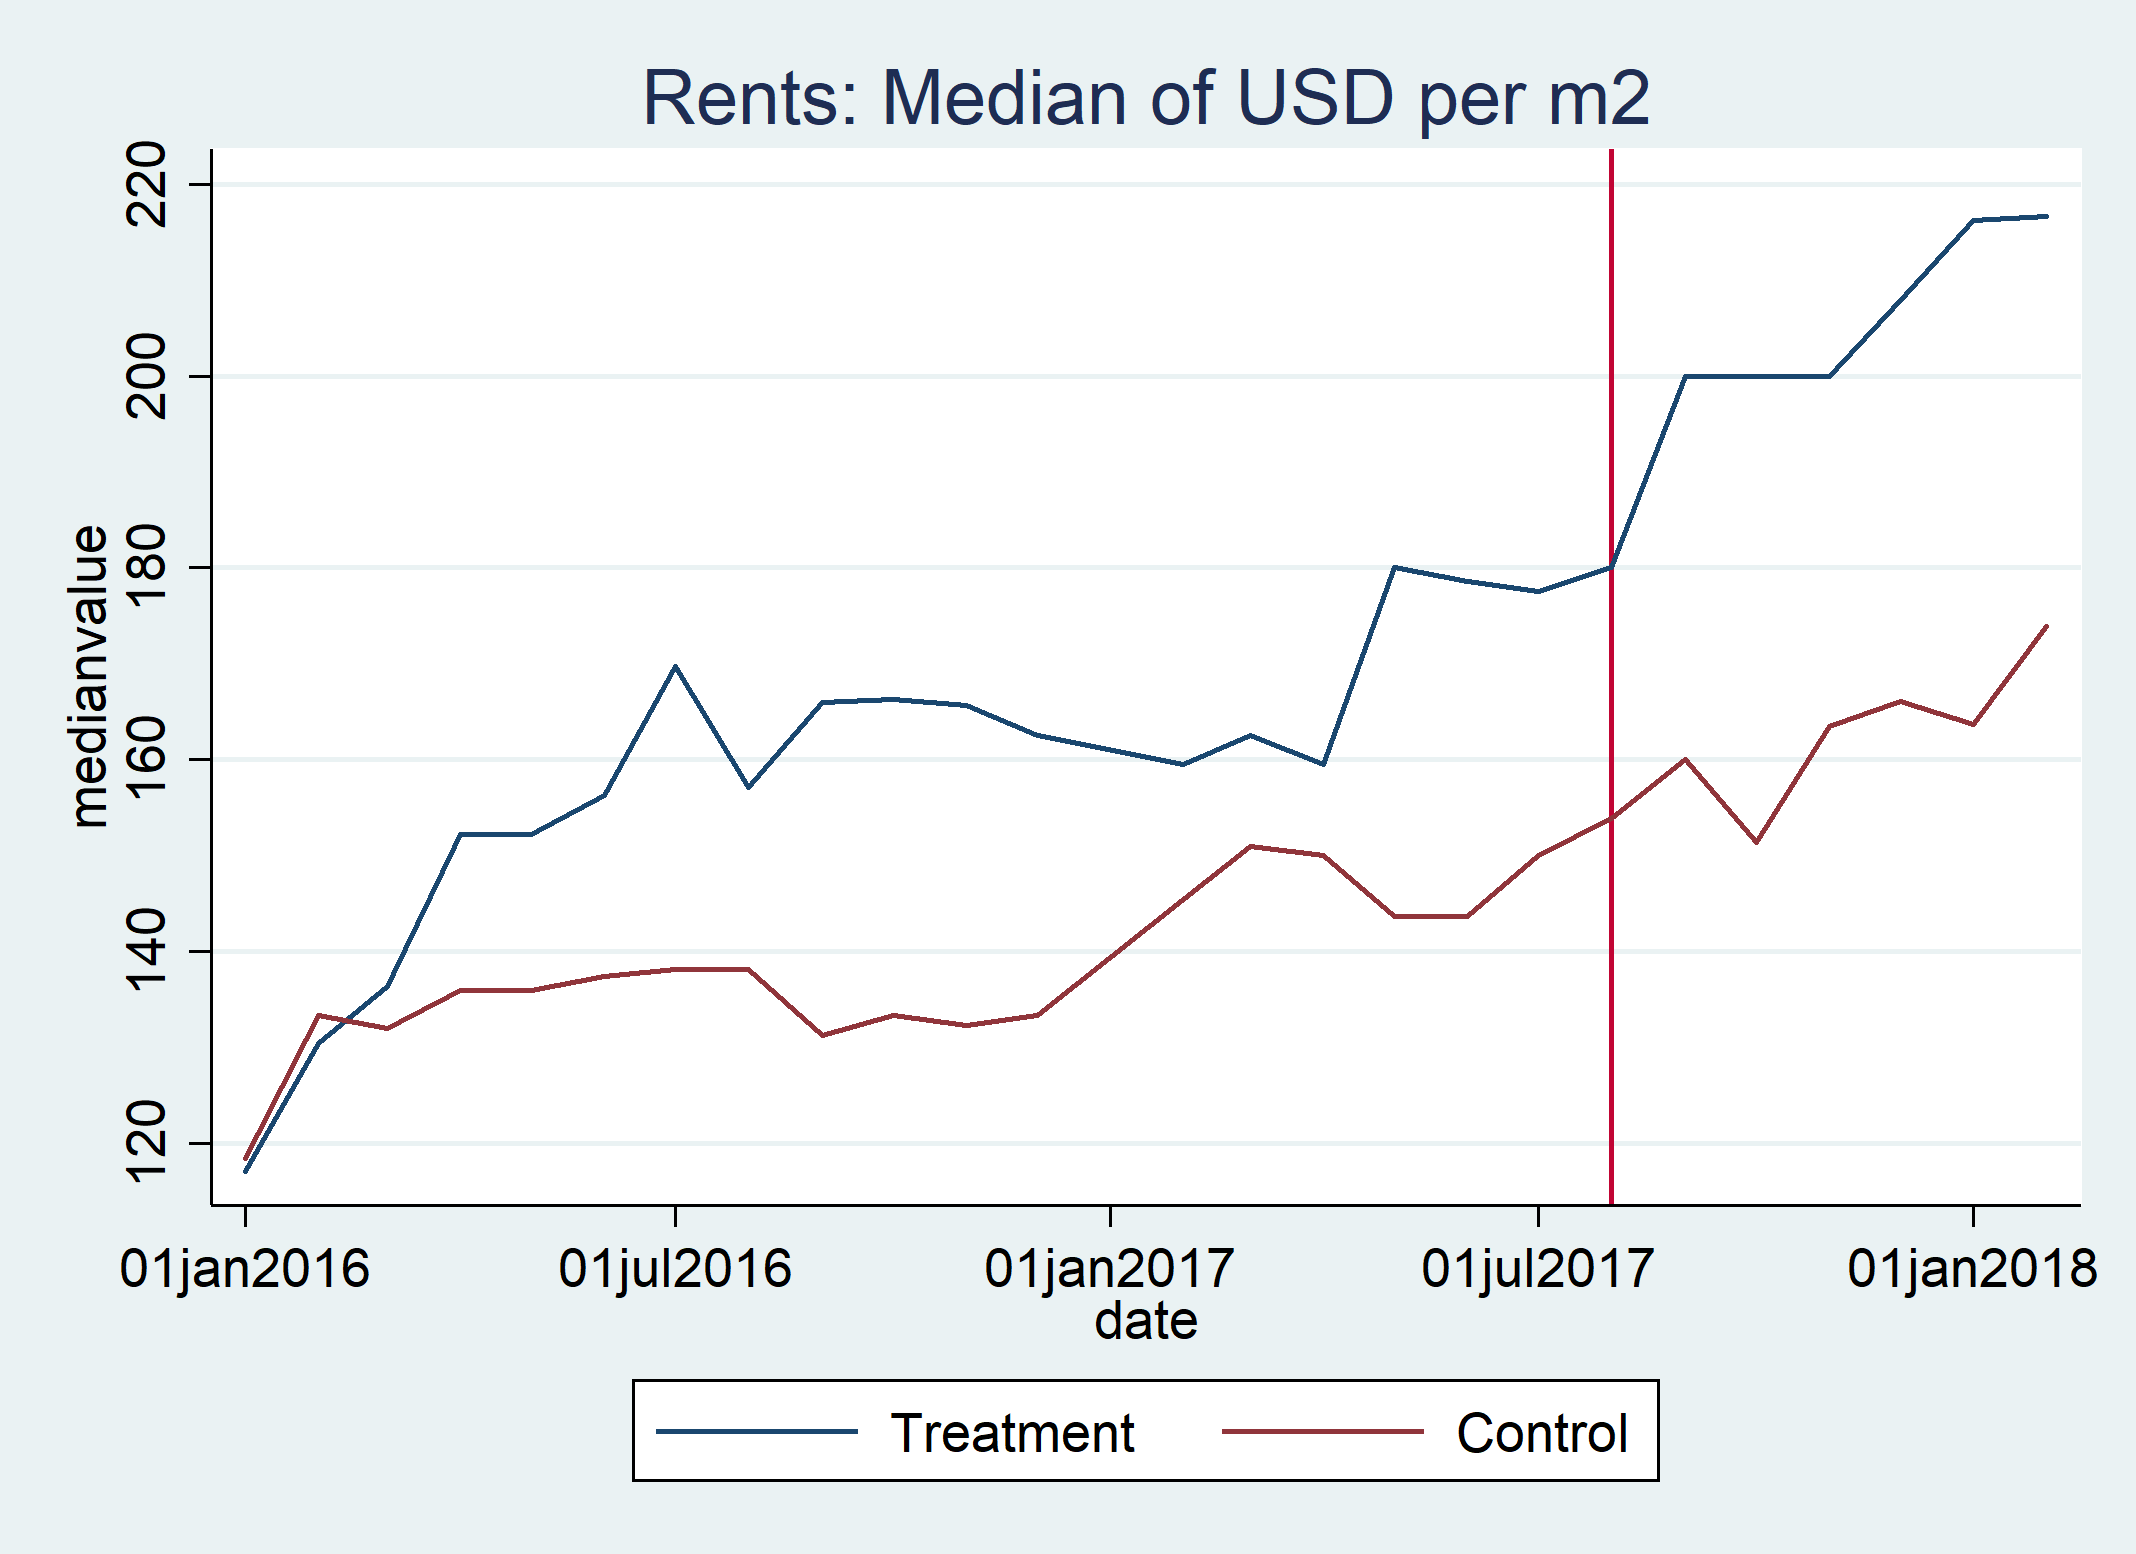

In [16]:
from IPython.display import Image
Image(filename='trends.png') 


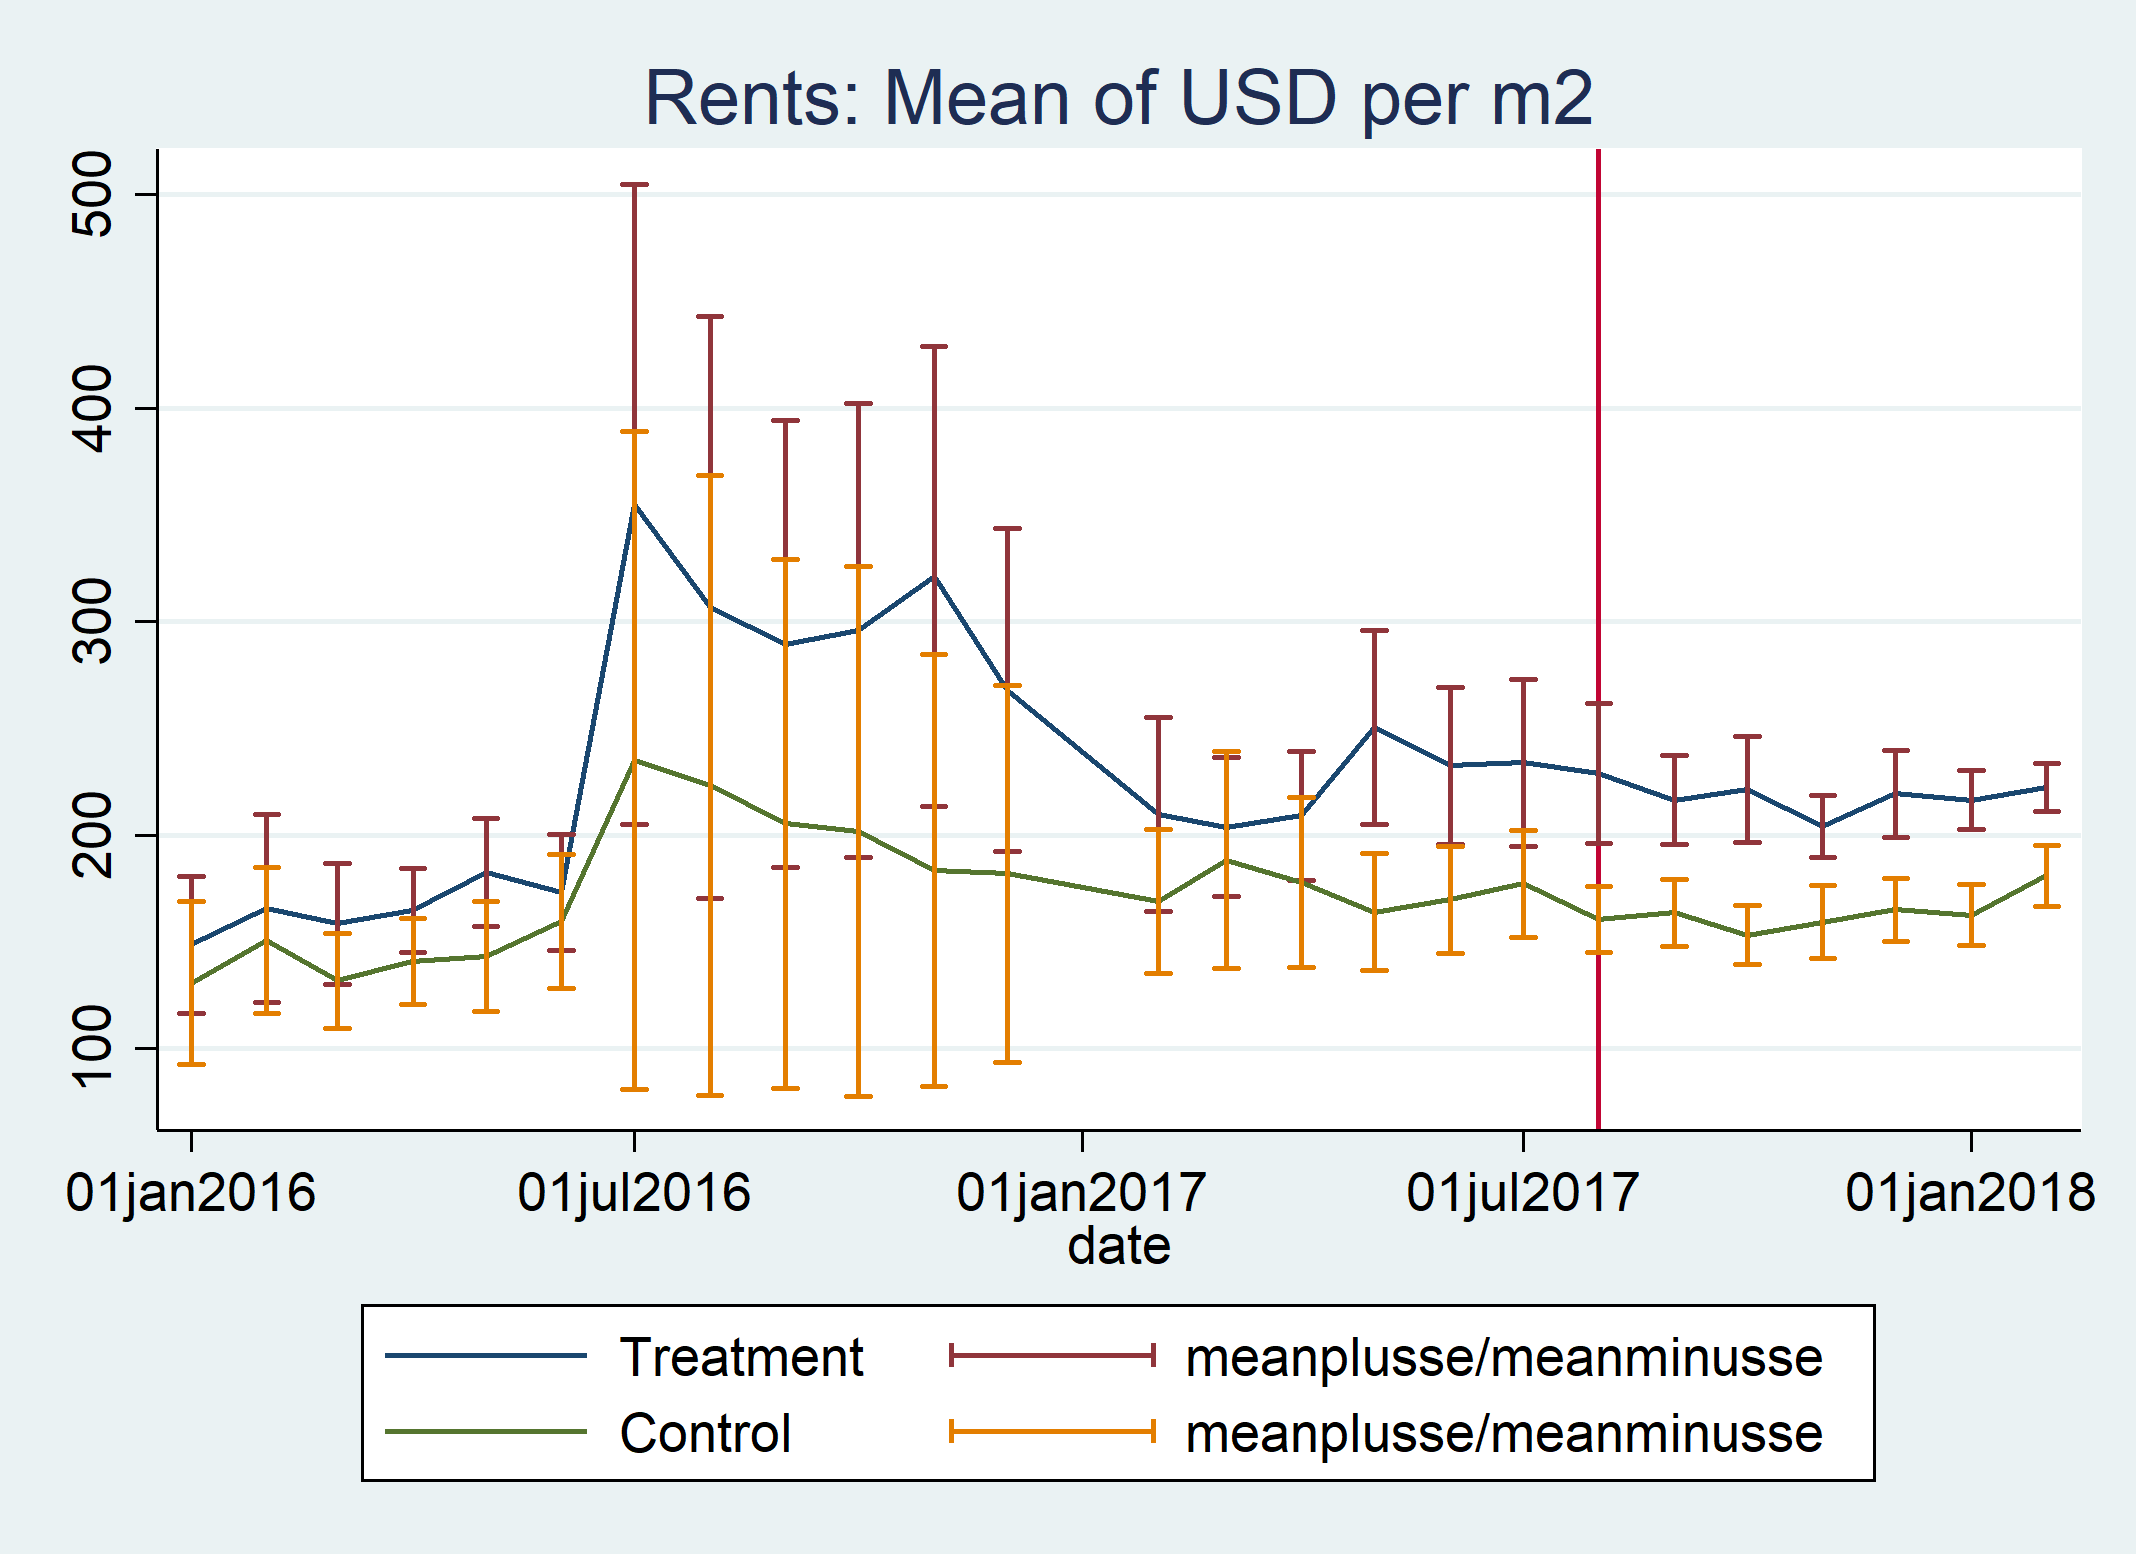

In [15]:
Image(filename='trends2.png') 